Avance 2 - Proyecto Final

En este notebook, se presenta el desarrollo de un sistema de análisis de ventas. El objetivo es procesar datos de ventas, cargarlos en una base de datos MySQL y realizar análisis complejos para extraer insights sobre el rendimiento de productos, sucursales y el comportamiento de los clientes. Se utilizarán principios de Programación Orientada a Objetos, patrones de diseño y SQL avanzado para construir una solución robusta y escalable.

In [1]:
from src.database.db_connector import DatabaseConnector

db = DatabaseConnector()
session = db.get_session()
print("Conexión exitosa")


Conexión exitosa


In [2]:
df = db.run_query("SELECT * FROM sales LIMIT 5")
df.head()

,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber
0,14,7,33133,406,9,0.00,63.00,1 days 15:52:00,VOP9A7Y4C5XSM2LLT0UJ
1,170,10,19039,377,5,0.00,50.00,1 days 09:40:00,VIIKLFPVD2D5U5E3NKKA
2,416,16,71212,351,19,0.00,304.00,1 days 16:57:00,QFA3F3LANPC6UVQBPYL2
3,486,23,93253,417,24,0.00,552.00,2 days 11:29:00,6H8SDUI9MCA1IXZ4UCUE
4,659,13,65151,147,17,0.20,221.00,1 days 03:58:01,1O062RUFV0LVAQ94G38J


Patrones de diseño
Definición de Clases y Patrones de Diseño
Patron factory

In [3]:
from src.factories.model_factory import ModelFactory

row = {
    "CustomerID": 1,
    "FirstName": "Juan",
    "MiddleInitial": "M",
    "LastName": "Perez",
    "CityID": 1,
    "Address": "martinez 123",
}

customer = ModelFactory.create_customer(row)
print(customer.__dict__)


{'_customer_id': 1, '_first_name': 'Juan', '_middle_initial': 'M', '_last_name': 'Perez', '_city_id': 1, '_address': 'martinez 123'}


Implementación del patron Builder se mostrara con el SQL

5. Análisis de Ventas con SQL Avanzado

En esta sección, se realizan consultas complejas para responder a preguntas clave del negocio.

5.1. Ranking de Productos Más Vendidos por Categoría

Pregunta de Negocio: ¿Cuáles son los 3 productos más vendidos (en cantidad) para cada categoría?

*Técnica SQL:* Función de Ventana RANK() OVER (PARTITION BY ...).

In [4]:
query_ranking = """
    SELECT
        CategoryName,
        ProductName,
        TotalQuantity,
        ProductRank
    FROM (
        SELECT
            c.CategoryName,
            p.ProductName,
            SUM(s.Quantity) AS TotalQuantity,
            RANK() OVER (PARTITION BY c.CategoryName ORDER BY SUM(s.Quantity) DESC) AS ProductRank
        FROM sales s
        JOIN products p ON s.ProductID = p.ProductID
        JOIN categories c ON p.CategoryID = c.CategoryID
        GROUP BY c.CategoryName, p.ProductName
    ) AS RankedProducts
    WHERE ProductRank <= 3;
"""
df_ranking = db.run_query(query_ranking)

print("Ranking de Productos:")
display(df_ranking)

Ranking de Productos:


,CategoryName,ProductName,TotalQuantity,ProductRank
0,Beverages,Garlic - Primerba; Paste,1937,1
1,Beverages,Tia Maria,1712,2
2,Beverages,Tray - 16in Rnd Blk,1632,3
3,Cereals,Brandy - Bar,1904,1
4,Cereals,Coconut - Shredded; Sweet,1896,2
5,Cereals,Vinegar - Tarragon,1830,3
6,Confections,Sprouts - Alfalfa,1910,1
7,Confections,Soup - Campbells; Beef Barley,1858,2
8,Confections,Soup - Campbells Tomato Ravioli,1728,3
9,Dairy,Nantucket - Pomegranate Pear,1657,1


Visualización del Ranking de Productos por Categoría


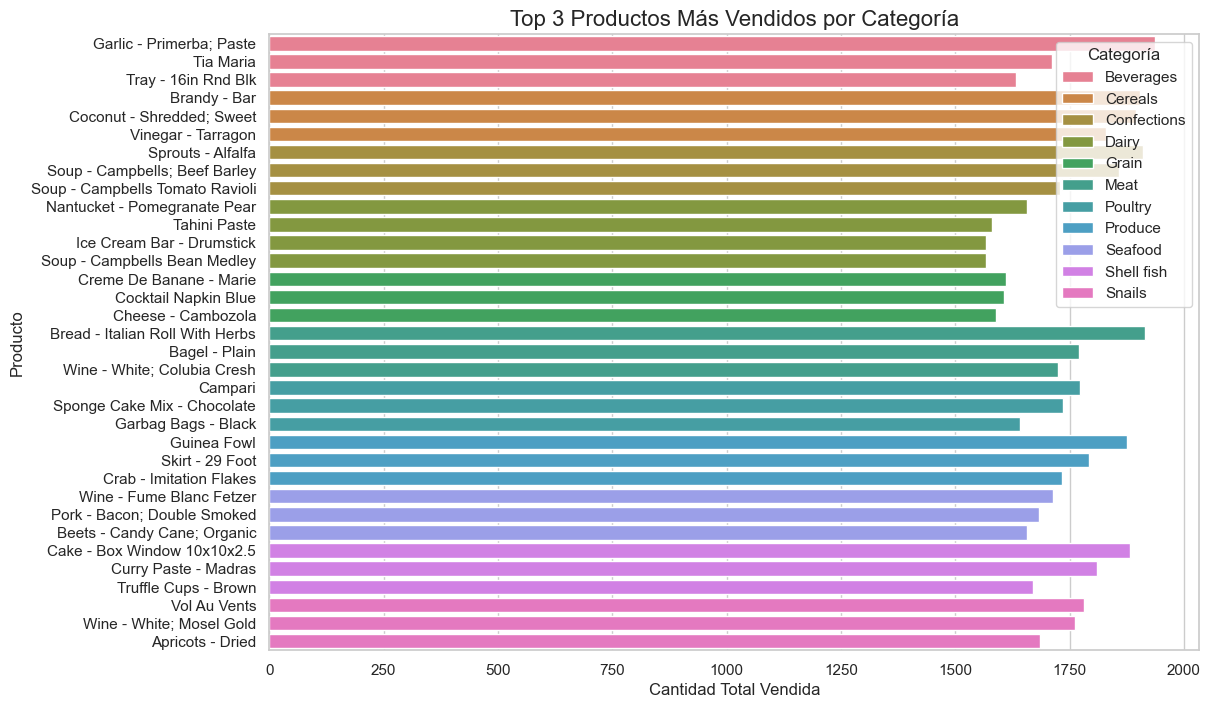

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualización del Ranking de Productos por Categoría")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

barplot = sns.barplot(
    data=df_ranking,
    x="TotalQuantity",
    y="ProductName",
    hue="CategoryName",
    dodge=False 
)

plt.title("Top 3 Productos Más Vendidos por Categoría", fontsize=16)
plt.xlabel("Cantidad Total Vendida", fontsize=12)
plt.ylabel("Producto", fontsize=12)
plt.legend(title="Categoría")
plt.show()

5.2. Uso del `SalesQueryBuilder` para Consultas Dinámicas

Ahora, usamos nuestro `SalesQueryBuilder` para encontrar las ventas del cliente con ID 80528 y una cantidad mínima de 2 unidades

In [6]:
from src.builder.sale_query_builder import SalesQueryBuilder
from src.database.db_connector import DatabaseConnector

builder = SalesQueryBuilder()
query_string, params = builder.with_customer(80528).with_min_quantity(2).build()

print("Consulta Construida:", query_string)
print("Parámetros:", params)

db = DatabaseConnector()
df_builder_result = db.run_query(query_string, params)

display(df_builder_result)

Consulta Construida: SELECT * FROM sales WHERE CustomerID = :customer_id AND Quantity >= :min_quantity
Parámetros: {'customer_id': 80528, 'min_quantity': 2}


,SalesID,SalesPersonID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber
0,3390545,2,80528,204,21,0.00,42.00,1 days 07:24:00,XJT3G8AY1MBCW4MSD67M


5.2. Análisis de Gasto por Cliente (usando CTE)

*Pregunta de Negocio:* ¿Quiénes son nuestros clientes más valiosos en una ciudad específica? Queremos identificar a los clientes con el mayor gasto total para posibles campañas de fidelización.

*Técnica SQL:* Se utilizará una Expresión de Tabla Común (CTE) llamada CustomerSpending para primero calcular el gasto total y el número de compras por cliente. Luego, se unirá este resultado con la tabla de clientes para obtener sus nombres y filtrar por ciudad. El uso de un CTE hace que la consulta sea más legible y modular.

In [7]:
from src.database.db_connector import DatabaseConnector
db = DatabaseConnector()
query_customer_spending = """
        WITH CustomerSpending AS (
            SELECT CustomerID, SUM(TotalPrice) AS TotalSpent
            FROM sales GROUP BY CustomerID
        )
        SELECT c.CustomerID, c.FirstName, cs.TotalSpent
        FROM customers c JOIN CustomerSpending cs ON c.CustomerID = cs.CustomerID
        WHERE c.CityID = 1 ORDER BY cs.TotalSpent DESC LIMIT 10;
    """

print("Ejecutando consulta para analizar el gasto por cliente:")
df_customer_spending = db.run_query(query_customer_spending)

display(df_customer_spending)

Ejecutando consulta para analizar el gasto por cliente:


,CustomerID,FirstName,TotalSpent
0,89007,Jolene,1426.00
1,91842,Antonio,1128.00
2,96549,Shirley,1000.00
3,76130,Monte,920.00
4,47949,Tyler,897.00
5,79075,Jennifer,882.00
6,95810,Bryce,850.00
7,98145,Sheldon,850.00
8,98021,Marc,800.00
9,70758,Brent,792.00


6. Uso de Vistas y Procedimientos Almacenados

Finalmente, demostramos el uso de los objetos SQL creados para simplificar y automatizar el acceso a los datos.

6.1. Consulta a la Vista `V_SalesOverview`

In [8]:
df_view = db.run_query("SELECT * FROM V_SalesOverview LIMIT 10;")
display(df_view)

,SalesID,SalesDate,ProductName,CategoryName,Quantity,TotalPrice,CustomerName,CityName,CountryName,SalesPersonName
0,1379,1 days 00:52:01,Ice Cream Bar - Drumstick,Dairy,14,14.00,Dianna Whitehead,Spokane,United States,Nicole Fuller
1,7884,1 days 14:52:01,Scampi Tail,Dairy,11,11.00,Alfred Shelton,Lincoln,United States,Nicole Fuller
2,10389,1 days 23:34:00,Wine - Sogrape Mateus Rose,Beverages,22,22.00,Sonja French,San Jose,United States,Nicole Fuller
3,10628,0 days 22:36:00,Vanilla Beans,Poultry,22,22.00,Marcella Mcclain,Shreveport,United States,Nicole Fuller
4,13687,1 days 16:58:01,Bread - Rye,Cereals,13,13.00,Alvin Caldwell,Wichita,United States,Nicole Fuller
5,14088,1 days 15:37:00,Cinnamon Buns Sticky,Cereals,17,17.00,Shelley Parks,Little Rock,United States,Nicole Fuller
6,14302,0 days 03:58:00,Coffee Decaf Colombian,Shell fish,24,24.00,Kelli Conner,Jersey,United States,Nicole Fuller
7,18254,2 days 02:37:01,Wine - Blue Nun Qualitatswein,Produce,17,17.00,Troy Liu,Hialeah,United States,Nicole Fuller
8,21627,2 days 07:42:00,Sprouts - Alfalfa,Confections,19,19.00,Jay Stewart,Miami,United States,Nicole Fuller
9,34572,1 days 02:18:00,Salsify; Organic,Grain,11,11.00,Roxanne Carson,Jackson,United States,Nicole Fuller


6.2. Llamada al Procedimiento Almacenado `SP_GetProductSales`

In [ ]:
from src.database.db_connector import DatabaseConnector

db_sp = DatabaseConnector()
df_sp = db_sp.call_stored_procedure("SP_GetProductSales_V2")
print(df_sp)

[]


TESTS

In [10]:
!pytest -q test/ --tb=short

FFF.........                                                             [100%]
================================== FAILURES ===================================
______________________________ test_descripcion _______________________________
test\test_category.py:9: in test_descripcion
    assert categoria.descripcion() == "Categoría: Confections"
E   AttributeError: 'Category' object has no attribute 'descripcion'
_____________________________ test_city_ubicacion _____________________________
test\test_city.py:9: in test_city_ubicacion
    assert city.ubicacion() == "Armenia (an)"
E   AttributeError: 'City' object has no attribute 'ubicacion'
___________________________ test_country_codigo_iso ___________________________
test\test_country.py:8: in test_country_codigo_iso
    assert country.codigo_iso() == "AN"
E   AttributeError: 'Country' object has no attribute 'codigo_iso'
=========================== short test summary info ===========================
FAILED test/test_category.py::te